<a href="https://colab.research.google.com/github/ngernest/URPS_Spring_2022/blob/main/URPS_Simulations_(fixed).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Software installation code

In [ ]:
# Install Pygraphon package for working with graphons from github
# !pip install git+https://github.com/dicai/pygraphon.git
# !git clone https://github.com/dicai/pygraphon.git
# !python2.7 /content/pygraphon/setup.py install

In [ ]:
# Install Python 3.9
!sudo apt-get update -y
!sudo apt-get install python3.9

#change alternatives
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 2

#check python version
!python --version
#3.9.6

In [ ]:
!sudo apt install python3-pip

In [ ]:
!sudo apt install python3.9-distutils

In [ ]:
!python3 -m pip install --upgrade pip

In [ ]:
import numpy as np
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

## Simulation code

In [ ]:
# Helper function for checking if a matrix is symmetric
# https://stackoverflow.com/questions/42908334/checking-if-a-matrix-is-symmetric-in-numpy
def check_symmetric(a, rtol=1e-08, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [ ]:
# Code for generating symmetric adjacency matrices for random graphs inspired by:
# https://stackoverflow.com/questions/10806790/generating-symmetric-matrices-in-numpy


def simulate_graphon(n, r, num_iterations, W, graphon_name, has_constant_clique_count = False, is_normal = False):
  clique_counts = defaultdict(int)

  for i in range(num_iterations):
    # Types U_1, ..., U_n
    U = np.random.uniform(low=0, high=1, size=n)

    prob_matrix = np.array(
        [np.array([W(U[i], U[j]) for j in range(n)]) for i in range(n)]
    )

    # Populate lower diagonal entries of adjacency matrix according to edge probabilties
    adj = np.zeros((n, n))
    for i in range(n):
      for j in range(i):
        adj[i, j] = np.random.binomial(1, prob_matrix[i, j])

    # Make adjacency matrix symmetric
    adj = np.tril(adj) + np.tril(adj, 1).T

    G = nx.from_numpy_matrix(adj)
    
    # NB: change to nx.find_cliques(G) for faster performance
    # NB: use nx.enumerate_all_cliques(G) for more accurate clique_counts

    if has_constant_clique_count:
      num_r_cliques = len([clique for clique in nx.enumerate_all_cliques(G) if len(clique) == r])
    else:
      num_r_cliques = len([clique for clique in nx.find_cliques(G) if len(clique) == r])

    clique_counts[num_r_cliques] += 1

  # Compute frequencies
  clique_frequencies = np.array(list(clique_counts.values())) / num_iterations

  mean_clique_count = np.mean(list(clique_counts.keys()))

  transformed_clique_count = (list(clique_counts.keys()) - mean_clique_count) / (n ** (r - 1))

  transformed_clique_count = np.array(transformed_clique_count)

  # sns.set_style('whitegrid')
  # plot = sns.kdeplot(x=np.array(transformed_clique_count), y = clique_frequencies, bw=0.5)
  if has_constant_clique_count:
    plt.bar(list(clique_counts.keys()), clique_frequencies, color='g', width=0.0005)
    plt.xticks(list(clique_counts.keys()))
    plt.title(f"Distribution of No. of {r}-cliques for {graphon_name}")
    plt.xlabel(f"No. of {r}-Cliques")
  else:
    plt.bar(transformed_clique_count, clique_frequencies, color='g', width=0.0005)
    # Display x-axis labels using scientific notation
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.title(f"Distribution of No. of {r}-cliques (Scaled and Centred) for {graphon_name}")
    plt.xlabel(f"No. of {r}-cliques (Scaled and Centered)")

    ax = plt.gca()

    plt.xlim(-1*1e-2, 1*1e-2)

    # recompute the ax.dataLim
    # ax.relim()
    # update ax.viewLim using the new dataLim
    # ax.autoscale()

  plt.ylabel("Density")

  # Three sigma limit for displaying normal distributions
  if is_normal:
    mu = np.mean(transformed_clique_count)
    sigma = np.std(transformed_clique_count)
    plt.xlim(mu - 3 * sigma, mu + 3 * sigma)

  plt.savefig(f"{graphon_name}, n = {n}, r = {r}, {num_iterations} iterations.png", bbox_inches='tight', dpi=144)


### Simulations for the graphon $W(x, y) = xy$

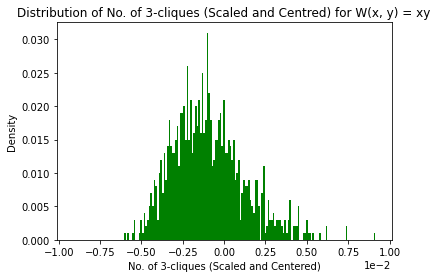

In [ ]:
# NB: This cell takes 49 seconds to run
n = 100
r = 3
num_iterations = 1000
W = lambda x, y: x * y
simulate_graphon(n, r, num_iterations, W, "W(x, y) = xy", has_constant_clique_count = False, is_normal = True)

### Constant graphons

In [ ]:
n = 5
r = 3
num_iterations = 1000
W = lambda x, y: 1
simulate_graphon(n, r, num_iterations, W, "$W(x, y) = 1$", True)

In [ ]:
n = 5
r = 3
num_iterations = 1000
W = lambda x, y: 1 if x != y else 0
simulate_graphon(n, r, num_iterations, W, "$W(x, y) = 1$ if $x$ ≠ $y$ else $0$", has_constant_clique_count = True, is_normal = False)

### Experimenting with example from $K_3$-regular graphon on p.9 of Hladky et al.

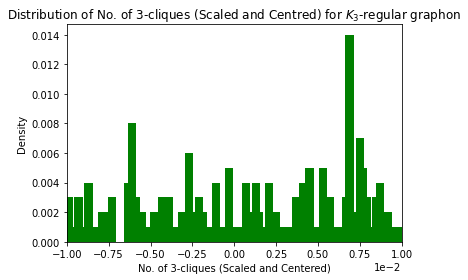

In [ ]:
# This cell takes 2m24s to run
n = 100
r = 3
interval_bounds = np.linspace(0, 1, num=7)
def block_graphon(x, y):
  if interval_bounds[0] <= x <= interval_bounds[1]:
    if interval_bounds[1] <= y <= interval_bounds[2] or interval_bounds[2] <= y <= interval_bounds[3]:
      return 1
    elif interval_bounds[3] <= y <= interval_bounds[4]:
      return 0.7
    else:
      return 0
  elif interval_bounds[1] <= x <= interval_bounds[2]:
    if interval_bounds[0] <= y <= interval_bounds[1] or interval_bounds[2] <= y <= interval_bounds[3]:
      return 1
    else:
      return 0
  elif interval_bounds[2] <= x <= interval_bounds[3]:
    if interval_bounds[0] <= y <= interval_bounds[1] or interval_bounds[1] <= y <= interval_bounds[2]:
      return 1
    else:
      return 0
  elif interval_bounds[3] <= x <= interval_bounds[4]:
    if interval_bounds[4] <= y <= interval_bounds[5] or interval_bounds[5] <= y <= interval_bounds[6]:
      return 1
    elif interval_bounds[0] <= y <= interval_bounds[1]:
      return 0.7
    else:
      return 0
  elif interval_bounds[4] <= x <= interval_bounds[5]:
    if interval_bounds[3] <= y <= interval_bounds[4] or interval_bounds[5] <= y <= interval_bounds[6]:
      return 1
    else:
      return 0
  elif interval_bounds[5] <= x <= interval_bounds[6]:
    if interval_bounds[3] <= y <= interval_bounds[4] or interval_bounds[4] <= y <= interval_bounds[5]:
      return 1
    else:
      return 0


simulate_graphon(n, r, 1000, block_graphon, "$K_3$-regular graphon", has_constant_clique_count = False, is_normal = False)

## Discarded simulations below:

In [ ]:

# Plot the distribution of 
# using Kernel Density Estimation
# sns.set_style('whitegrid')
# ax = sns.kdeplot(clique_counts.values(), bw=0.5)

defaultdict(int, {10: 1})

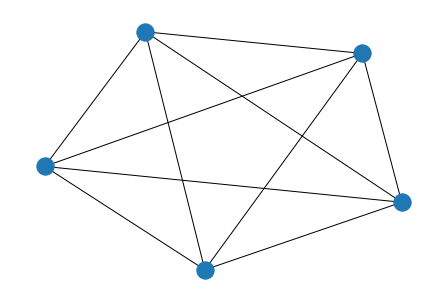

In [ ]:
n = 5
r = 3
W = lambda x, y: 1
U = np.random.uniform(low=0, high=1, size=n)
prob_matrix = np.array(
    [np.array([W(U[i], U[j]) for j in range(n)]) for i in range(n)]
)

# Populate lower diagonal entries of adjacency matrix according to edge probabilties
adj = np.zeros((n, n))
for i in range(n):
  for j in range(i):
    adj[i, j] = np.random.binomial(1, prob_matrix[i, j])

# Make adjacency matrix symmetric
adj = np.tril(adj) + np.tril(adj, 1).T

G = nx.from_numpy_matrix(adj)
nx.draw(G)

clique_counts = defaultdict(int)
num_r_cliques = len([clique for clique in nx.enumerate_all_cliques(G) if len(clique) == r])

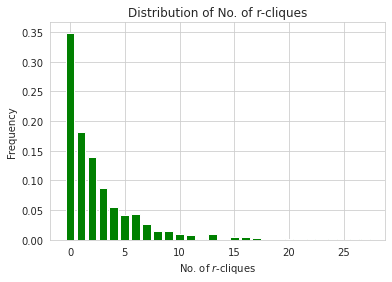

In [ ]:
# Code for generating symmetric adjacency matrices for random graphs inspired by:
# https://stackoverflow.com/questions/10806790/generating-symmetric-matrices-in-numpy


n = 50
r = 3
num_iterations = 1000

W = lambda x, y: ((1-x) + (1-y)) / 2
num_cliques = defaultdict(int)

clique_counts = defaultdict(int)

for i in range(num_iterations):
  # Types U_1, ..., U_n
  U = np.random.uniform(low=0, high=1, size=n)

  prob_matrix = np.array(
      [np.array([W(U[i], U[j]) for j in range(n)]) for i in range(n)]
  )

  # Populate lower diagonal entries of adjacency matrix according to edge probabilties
  adj = np.zeros((n, n))
  for i in range(n):
    for j in range(i):
      adj[i, j] = np.random.binomial(1, prob_matrix[i, j])

  # Make adjacency matrix symmetric
  adj = np.tril(adj) + np.tril(adj, 1).T

  G = nx.from_numpy_matrix(adj)
  
  num_r_cliques = len([clique for clique in nx.find_cliques(G) if len(clique) == r])

  clique_counts[num_r_cliques] += 1


# Compute frequencies
clique_frequencies = np.array(list(clique_counts.values())) / num_iterations

plt.bar(list(clique_counts.keys()), clique_frequencies, color='g')
plt.xlabel("No. of $r$-cliques")
plt.ylabel("Frequency")
plt.title("Distribution of No. of r-cliques")
plt.show()

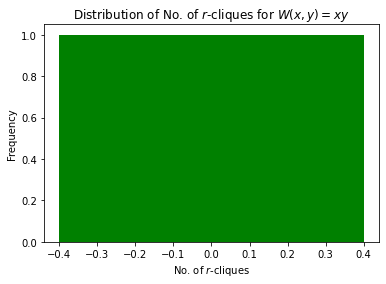

In [ ]:
def SBM(p1=0.05, p2=0.5, q=0.4):
    return lambda x, y: p1 if (x < q and y >= q) or (x >= q and y < q) else p2

n = 5
r = 3
num_iterations = 1000
W = SBM(p1 = 1, p2 = 0)
simulate_graphon(n, r, num_iterations, W, "SBM, p1 = 1, p2 = 0")

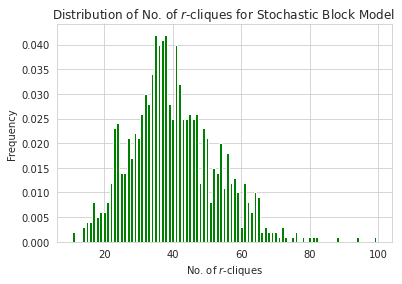

In [ ]:
# Code for generating symmetric adjacency matrices for random graphs inspired by:
# https://stackoverflow.com/questions/10806790/generating-symmetric-matrices-in-numpy


n = 50
r = 3

num_iterations = 1000

W = SBM()
num_cliques = defaultdict(int)

clique_counts = defaultdict(int)

for i in range(num_iterations):
  # Types U_1, ..., U_n
  U = np.random.uniform(low=0, high=1, size=n)

  prob_matrix = np.array(
      [np.array([W(U[i], U[j]) for j in range(n)]) for i in range(n)]
  )

  # Populate lower diagonal entries of adjacency matrix according to edge probabilties
  adj = np.zeros((n, n))
  for i in range(n):
    for j in range(i):
      adj[i, j] = np.random.binomial(1, prob_matrix[i, j])

  # Make adjacency matrix symmetric
  adj = np.tril(adj) + np.tril(adj, 1).T

  G = nx.from_numpy_matrix(adj)
  
  num_r_cliques = len([clique for clique in nx.find_cliques(G) if len(clique) == r])

  clique_counts[num_r_cliques] += 1


# Compute frequencies
clique_frequencies = np.array(list(clique_counts.values())) / num_iterations


plt.bar(list(clique_counts.keys()), clique_frequencies, color='g')
plt.xlabel("No. of $r$-cliques")
plt.ylabel("Frequency")
plt.title("Distribution of No. of $r$-cliques for Stochastic Block Model")
plt.show()

# Plot the distribution of 
# using Kernel Density Estimation
# sns.set_style('whitegrid')
# ax = sns.kdeplot(clique_counts.values(), bw=0.5)